In [1]:
!pip install transformers

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
import pandas as pd
from transformers import AutoTokenizer, AdamW, get_scheduler, AutoModelForSequenceClassification
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dataset_path = "/content/drive/MyDrive/dataset/bert_train_preprocessed.txt"
test_dataset_path = "/content/drive/MyDrive/dataset/bert_test_preprocessed.txt"

In [6]:
train_df = pd.read_csv(train_dataset_path, sep="\t")
test_df = pd.read_csv(test_dataset_path, sep="\t")

test_df.head()

,index,label,text
0,1,0,@USER Can U Help ? | | More conservatives need...
1,2,1,"Just walked in to #Starbucks and asked for a ""..."
2,3,0,#NOT GONNA WIN HTTPURL
3,4,0,@USER He is exactly that sort of person . Weir...
4,5,1,So much #sarcasm at work mate 10/10 #boring 10...


In [7]:
class SarcasticSentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        if len(sentences) != len(labels):
            raise ValueError("Sentences and labels should have the same number of elements.")

        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index: int):
        inputs = self.tokenizer(self.sentences[index],
                                truncation=True,
                                pad_to_max_length=True,
                                return_tensors="pt",
                                max_length=self.max_len)

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.sentences)

In [8]:
from tqdm.auto import tqdm
import copy


def train(model, 
          train_loader, 
          eval_loader,
          device, 
          lr=5e-5,
          num_epochs=5,
          batch_size=8):
        
    num_training_steps = len(train_loader) * num_epochs
    optimizer, lr_scheduler = setup_optimizer_and_scheduler(model,
                                                         lr,
                                                         0,
                                                         num_training_steps)

    progress_bar = tqdm(range(num_training_steps))
    
    best_f1 = 0
    best_epoch = -1
    best_params = copy.deepcopy(model.state_dict())
    patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            
        metrics = evaluate(model, eval_loader, device)
        print(f"valid accuracy: {metrics['accuracy']}\n"
              f"valid precision: {metrics['precision']}\n"
              f"valid recall: {metrics['recall']}\n"
              f"valid f1: {metrics['f1']}\n")
            
        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            best_epoch = epoch
            best_params = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        print(f"patience: {patience}\n")
        if patience == 3:
            break
        
    print(f"best epoch: {best_epoch}\n"
          f"best f1: {best_f1}\n")

    model.load_state_dict(best_params)
    return model


def setup_optimizer_and_scheduler(model, lr, num_warmup_steps, num_training_steps):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler = get_scheduler(name="linear", 
                                             optimizer=optimizer,
                                             num_warmup_steps=num_warmup_steps,
                                             num_training_steps=num_training_steps)
    return optimizer, scheduler


def evaluate(model, eval_loader, device):
    model.eval()
    labels_list = []
    preds_list = []
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            _, preds = torch.max(outputs.logits, dim=1, keepdim=False)
            labels_list.extend(batch["labels"].cpu().numpy().tolist())
            preds_list.extend(preds.cpu().numpy().tolist())

    return compute_metrics(labels_list, preds_list)


def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

In [9]:
# Used for loading model and tokenizer
model_name = "distilbert-base-uncased"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
train_dataset = SarcasticSentenceDataset(sentences=train_df["text"].tolist(),
                                         labels=train_df["label"].tolist(),
                                         tokenizer=tokenizer)

test_dataset = SarcasticSentenceDataset(sentences=test_df["text"].tolist(),
                                        labels=test_df["label"].tolist(),
                                        tokenizer=tokenizer)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [11]:
# item = train_dataset[0]
# print(f"sentence: {train_df['text'][0]}\n"
#       f"ids: {item['input_ids']}\n"
#       f"attention_mask: {item['attention_mask']}\n"
#       f"label: {item['labels']}")

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [13]:
model = train(model,
              DataLoader(train_dataset, batch_size=8),
              DataLoader(test_dataset, batch_size=8),
              device,
              num_epochs=20,
              lr=5e-5)

  0%|          | 0/9560 [00:00<?, ?it/s]

valid accuracy: 0.6658163265306123
valid precision: 0.5890909090909091
valid recall: 0.5209003215434084
valid f1: 0.5529010238907851

patience: 0

valid accuracy: 0.6747448979591837
valid precision: 0.5752688172043011
valid recall: 0.6881028938906752
valid f1: 0.6266471449487555

patience: 0

valid accuracy: 0.6339285714285714
valid precision: 0.5272727272727272
valid recall: 0.7459807073954984
valid f1: 0.6178428761651131

patience: 1

valid accuracy: 0.6377551020408163
valid precision: 0.5267326732673268
valid recall: 0.8553054662379421
valid f1: 0.6519607843137256

patience: 0

valid accuracy: 0.6938775510204082
valid precision: 0.5847255369928401
valid recall: 0.7877813504823151
valid f1: 0.6712328767123289

patience: 0

valid accuracy: 0.6862244897959183
valid precision: 0.6025236593059937
valid recall: 0.6141479099678456
valid f1: 0.60828025477707

patience: 1

valid accuracy: 0.6530612244897959
valid precision: 0.5438202247191011
valid recall: 0.7781350482315113
valid f1: 0.6402

test accuracy: 0.6938775510204082
test precision: 0.5847255369928401
test recall: 0.7877813504823151
test f1: 0.6712328767123289



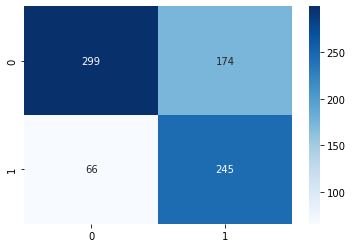

In [14]:
metrics = evaluate(model, DataLoader(test_dataset, batch_size=8), device)
print(f"test accuracy: {metrics['accuracy']}\n"
      f"test precision: {metrics['precision']}\n"
      f"test recall: {metrics['recall']}\n"
      f"test f1: {metrics['f1']}\n")

sns.heatmap(metrics["confusion_matrix"], annot=True, cmap='Blues', fmt="d")

In [15]:
torch.save(model.state_dict(), "model.pth")
print("model params saved")

model params saved
